In [1]:
import numpy as np

import nengo
from nengo.solvers import LstsqL2, NoSolver
from nengo.utils.matplotlib import rasterplot
from nengo.utils.ensemble import tuning_curves
from nengo.dists import Uniform
from nengo.params import Default

from nengolib.signal import s, nrmse
from nengolib.synapses import Lowpass

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='poster', style='whitegrid')
%matplotlib inline

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

from nengo_bioneurons import BahlNeuron

/home/pduggins/.virtualenvs/nengo_bioneuron/local/lib/python2.7/site-packages/nengo/builder/builder.py:234: UserWarning: Type '<class 'nengo.connection.Connection'>' already has a builder. Overwriting.
  % nengo_class)


# Signals

In [2]:
def make_stimulus(signal, freq, amp, seed):       
    if signal == 'cos':
        return nengo.Node(output=lambda t: np.cos(freq*t))
    elif signal == 'sin':
        return nengo.Node(output=lambda t: np.sin(freq*t))
    elif signal == 'white_noise':
        return nengo.Node(nengo.processes.WhiteSignal(
            period=100,
            high=freq,
            rms=amp,
            seed=seed))

In [3]:
def norms(signal, freq, amp, ss, tau, t, plot=False):
    # first find the norm of the filtered signal
    lpf=nengo.Lowpass(tau)
    with nengo.Network() as model:
        stim = make_stimulus(signal, freq, amp, ss)
        p_stim = nengo.Probe(stim, synapse=None)
        p_integral = nengo.Probe(stim, synapse=1/s)
    with nengo.Simulator(model, progress_bar=False) as sim:
        sim.run(t, progress_bar=False)
    stimulus = sim.data[p_stim]
    target = sim.data[p_integral]
    target_f = lpf.filt(sim.data[p_integral])
    norm_s = np.max(np.abs(stimulus))
    norm = np.max(np.abs(target))
    norm_f = np.max(np.abs(target_f))
    
    if plot:
        plt.plot(sim.trange(), stimulus)
        plt.plot(sim.trange(), target)
        plt.plot(sim.trange(), lpf.filt(sim.data[p_integral]/norm_f))
        plt.show()
    return norm, norm_s, norm_f

# Encoder Learning

Goal: learn the encoder at each synapse between "pre" and "bio" such that "bio"'s tuning curve approaches a target tuning curve.

Method: given $d_{pre}$, a desired tuning curve for "bio", and a current estimate for "activity" and $x \cdot e_{bio}$, update $e_{syn}$ to increase or decrease the magnitude of input current.

In [4]:
class EncoderNode(nengo.Node):
    def __init__(
            self,
            conn,
            n_bio,
            n_syn,
            dim,
            d_pre,
            eta,  # learning rate
            seed, # learning seed
            syn_encoders_init):
        
        self.conn = conn
        self.n_syn = n_syn
        self.dim = dim
        self.d_pre = d_pre
        self.eta = eta
        self.rng = np.random.RandomState(seed=seed)
        self.n_pre = self.d_pre.shape[0]
        self.n_bio = n_bio
        self.syn_encoders = syn_encoders_init
        self.a_target = np.array([])
        self.a_bio = np.array([])

        super(EncoderNode, self).__init__(self.update, 
            size_in=2*self.n_bio,  # [a_bio, a_lif]
            size_out=self.n_bio)

    def update(self, t, x):
        self.a_bio = x[0:self.n_bio]
        self.a_target = x[self.n_bio:2*self.n_bio]
        return self.a_bio - self.a_target
    
    def update_encoders(self, bio, pre, syn):
        a_error = self.a_bio[bio] - self.a_target[bio]
        d_syn = self.d_pre[pre]
        e_old = self.syn_encoders[bio, pre, syn]
        delta = self.rng.uniform(0, 2 * self.eta * np.abs(a_error))
            
        if a_error > 0 and d_syn > 0:  # overactive, positive dec => reduce enc reduce weight
            self.syn_encoders[bio, pre, syn] += -delta
        if a_error > 0 and d_syn < 0:  # overactive, negative dec => increase enc reduce weight
            self.syn_encoders[bio, pre, syn] += +delta
        if a_error < 0 and d_syn > 0:  # underactive, positive dec => increase enc increase weight
            self.syn_encoders[bio, pre, syn] += +delta
        if a_error < 0 and d_syn < 0:  # underactive, negative dec => reduce enc increase weight
            self.syn_encoders[bio, pre, syn] += -delta
            
        w_new = np.dot(d_syn, self.syn_encoders[bio, pre, syn])

        return w_new

### Plot tuning curves

In [5]:
def bin_activities_values_1d(
    xhat_pre,
    act_bio,
    x_min=-1,
    x_max=1,
    n_neurons=10,
    n_eval_points=20):

    def find_nearest(array,value):
        idx = (np.abs(array-value)).argmin()
        return idx

    x_bins = np.linspace(x_min, x_max, num=n_eval_points)
    hz_means = np.empty((n_neurons, n_eval_points))
    hz_stds = np.empty((n_neurons, n_eval_points))
    for i in range(n_neurons):
        bin_act = [[] for _ in range(x_bins.shape[0])]
        for t in range(act_bio.shape[0]):
            idx = find_nearest(x_bins, xhat_pre[t])
            bin_act[idx].append(act_bio[t, i])
        for x in range(len(bin_act)):
            hz_means[i, x] = np.average(bin_act[x])
            hz_stds[i, x] = np.std(bin_act[x])

    return x_bins, hz_means, hz_stds

# Simulate the network

In [6]:
def pre_bio(
    d_bio_out,
    t=1,
    n_neurons=10,
    n_syn=1,
    signal='sin',
    freq=1,
    amp=1,
    sec='tuft',
    eta=0,
    taus={'network': 0.05,
          'readout': 0.05},
    regs={'pre-bio': 0.1,
          'bio-out': 0.1},
    seeds={'ns': 1, 'ss':2, 'es': 3, 'cs': 4, 'ls': 5},
    neuron_type=BahlNeuron(bias_method='weights_fixed'),
    learning=True,
    syn_weights=None,
    verbose=True):
    
    norm, norm_s, norm_f = norms(signal, freq, amp, seeds['ss'], taus['network'], t)
    
    pre_kwargs = dict(
        n_neurons=100,
        dimensions=1,
        max_rates=Uniform(20, 40),
        seed=seeds['es'])
    
    lif_kwargs = dict(
        n_neurons=n_neurons,
        dimensions=1,
        max_rates=Uniform(20, 40),
        seed=seeds['es'],
        label='lif')
    
    conn_kwargs = dict(
        sec=sec,
        n_syn=n_syn,
        syn_type='ExpSyn',
        tau_list=[taus['network']],
        synapse=taus['network'],
        seed=seeds['cs'])
    
    bio_kwargs = dict(
        n_neurons=n_neurons,
        dimensions=1,
        encoders=Uniform(-1, 1),  # doesn't affect
        gain=Uniform(0, 0),
        bias=Uniform(0, 0),
        neuron_type=neuron_type,
        seed=seeds['es'],
        label='bio')
    
    # Build a network to collect encoders, gains, biases from target LIF
    with nengo.Network(seed=seeds['ns']) as pre_model:
        pre = nengo.Ensemble(**pre_kwargs)
        lif = nengo.Ensemble(**lif_kwargs)
        pre_lif = nengo.Connection(pre, lif, **conn_kwargs)
    sim = nengo.Simulator(pre_model, seed=seeds['ss'])
    d_pre = sim.data[pre_lif].weights.T
    e_target = sim.data[lif].encoders
    syn_encoders_init = np.zeros((n_neurons, 100, n_syn))
    for bio in range(syn_encoders_init.shape[0]):
        syn_encoders_init[bio] = e_target[bio] * np.ones((100, n_syn))
    
    # Simulate the full network with the encoder learning rule
    with nengo.Network(seed=seeds['ns']) as model:
        u = make_stimulus(signal, freq, amp, seeds['ss'])
        pre = nengo.Ensemble(**pre_kwargs)
        bio = nengo.Ensemble(**bio_kwargs)
        lif = nengo.Ensemble(**lif_kwargs)

        nengo.Connection(u, pre, synapse=None, transform=1.0/norm_s, seed=seeds['cs'])
        pre_bio = nengo.Connection(pre, bio, syn_weights=syn_weights, **conn_kwargs)
        pre_lif = nengo.Connection(pre, lif, **conn_kwargs)
        
        if learning:
            enc_node = EncoderNode(
                pre_bio,
                n_neurons,
                n_syn,
                1,
                d_pre,
                eta,  # learning rate
                seeds['ls'], # learning seed
                syn_encoders_init=syn_encoders_init)
            pre_bio.learning_node = enc_node
            nengo.Connection(bio.neurons, enc_node[0:n_neurons], synapse=taus['readout'])  # a_bio
            nengo.Connection(lif.neurons, enc_node[n_neurons:2*n_neurons], synapse=taus['readout'])  # a_lif
        
        p_target = nengo.Probe(u, synapse=None)
        p_spk_bio = nengo.Probe(bio.neurons, synapse=None)
        p_act_bio = nengo.Probe(bio.neurons, synapse=taus['readout'])
        p_act_lif = nengo.Probe(lif.neurons, synapse=taus['readout'])
        p_bio = nengo.Probe(bio, synapse=taus['readout'], solver=NoSolver(d_bio_out))

    with nengo.Simulator(model, seed=seeds['ss']) as sim:
        sim.run(t)

    target = nengo.Lowpass(taus['readout']).filt(sim.data[p_target])
    spikes_bio = sim.data[p_spk_bio]
    act_bio = sim.data[p_act_bio]
    act_lif = sim.data[p_act_lif]
    xhat_bio = sim.data[p_bio]
    nrmse_bio = nrmse(xhat_bio, target=target)
        
    x_bins, hz_means, hz_stds = bin_activities_values_1d(
        target,
        act_bio,
        n_neurons=n_neurons)
    x_bins_lif, hz_means_lif, hz_stds_lif = bin_activities_values_1d(
        target,
        act_lif,
        n_neurons=n_neurons)

    if verbose:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8))
        rasterplot(sim.trange(), spikes_bio, ax=ax1)
        ax1.set(xlabel='time', ylabel='neuron')
        sns.distplot(np.ravel(act_bio), ax=ax2)
        ax2.set(xlim=((1, 50)), ylim=((0, 0.05)), xlabel='activity', ylabel='frequency')

        fig, (ax3) = plt.subplots(1, 1, figsize=(8, 8))
        ax3.plot(sim.trange(), target, label='target', linestyle='--')
        ax3.plot(sim.trange(), xhat_bio, alpha=0.5, label='bio')
        ax3.set(xlim=((0, t)), ylim=((-1, 1)),
                xlabel='time', ylabel='$\mathbf{x}$', title='nrmse=%.3f'%nrmse_bio)
        ax3.legend(loc='lower left')
        
        cmap = sns.color_palette('hls', n_neurons)
        fig, (ax4, ax5) = plt.subplots(1, 2, figsize=(8, 8), sharey=True)
        for n in range(n_neurons):
            ax4.plot(x_bins_lif, hz_means_lif[n], c=cmap[n])
            ax4.fill_between(x_bins_lif,
                hz_means_lif[n]+hz_stds_lif[n],
                hz_means_lif[n]-hz_stds_lif[n],
                alpha=0.5, facecolor=cmap[n])
            ax5.plot(x_bins, hz_means[n], c=cmap[n])
            ax5.fill_between(x_bins,
                hz_means[n]+hz_stds[n],
                hz_means[n]-hz_stds[n],
                alpha=0.5, facecolor=cmap[n])
        ax4.set(xlim=((-1,1)), ylim=((0, 50)), xlabel='$\mathbf{x}$', ylabel='activity (Hz)', title='lif')
        ax5.set(xlim=((-1,1)), ylim=((0, 50)), xlabel='$\mathbf{x}$', title='bio')
        
        plt.tight_layout()
        plt.show()


    d_bio_out_new = LstsqL2(reg=regs['bio-out'])(act_bio, target)[0]
    syn_weights_new = sim.data[pre_bio].weights
                
    return d_bio_out_new, syn_weights_new

/home/pduggins/.virtualenvs/nengo_bioneuron/local/lib/python2.7/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:50.                                                 


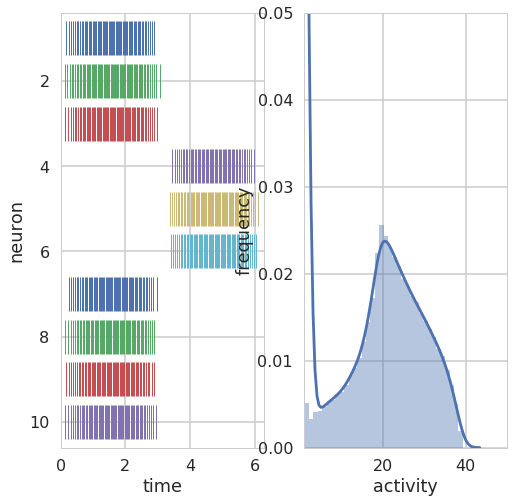

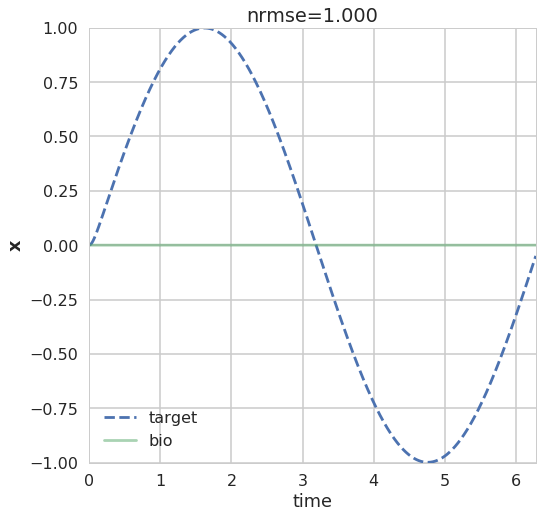

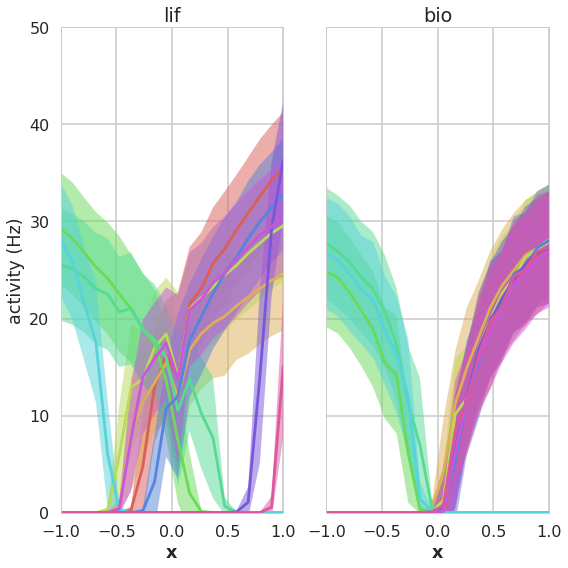

Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Simulating finished in 0:03:23.                                                 


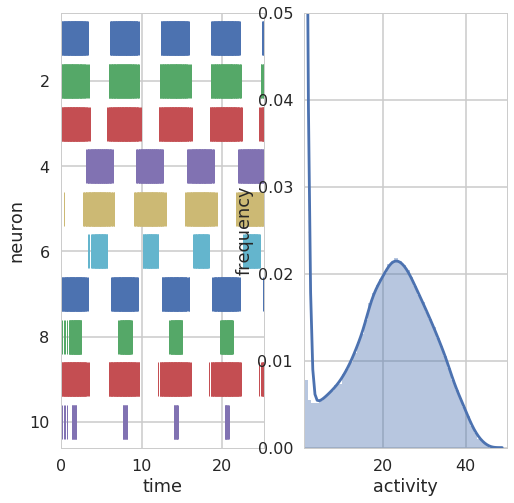

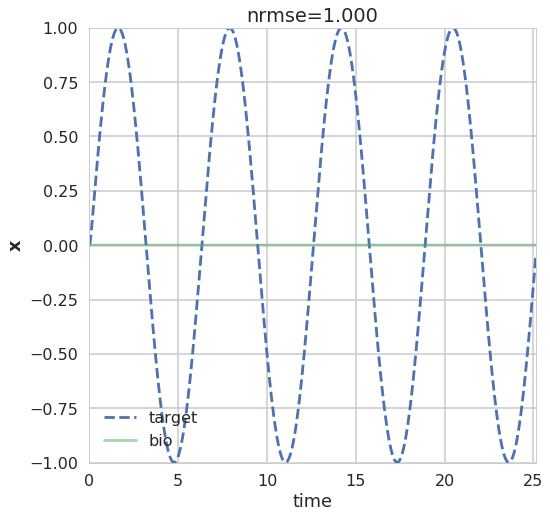

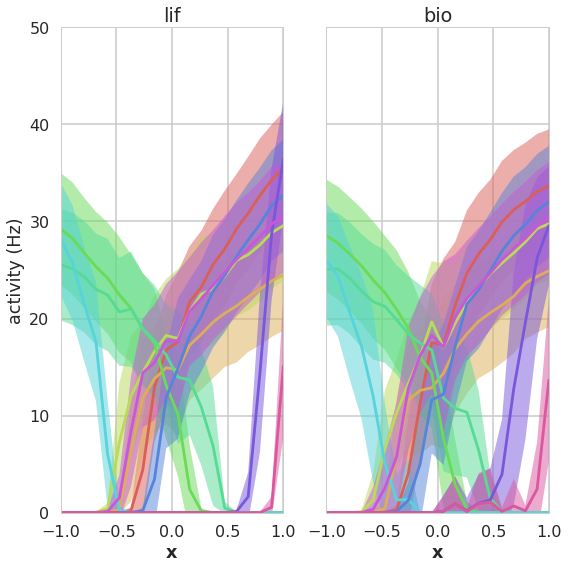

Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Simulating finished in 0:03:17.                                                 


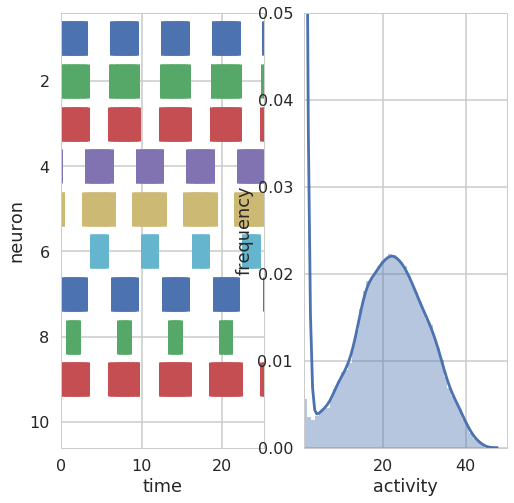

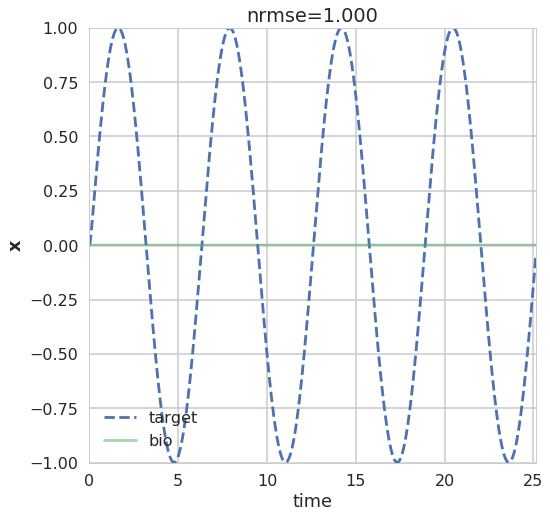

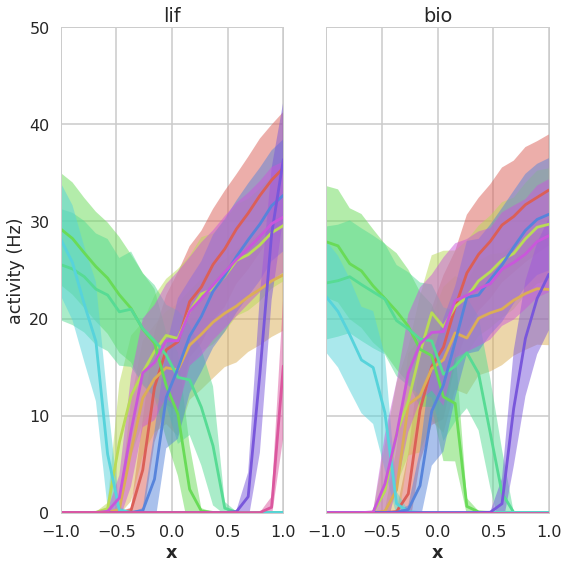

In [7]:
n_neurons = 10
n_syn = 1
freq = 1
eta = 0

d_bio_out_init = np.zeros((n_neurons, 1))
syn_weights_init = np.zeros((n_neurons, 100, n_syn))

t = 2*np.pi
_, _ = pre_bio(
    d_bio_out_init,
    t=t,
    freq=freq,
    n_neurons=n_neurons,
    n_syn=n_syn,
    eta=eta,
    syn_weights=syn_weights_init,
    verbose=True)

t = 8*np.pi
eta = 1e-2
_, syn_weights = pre_bio(
    d_bio_out_init,
    t=t,
    freq=freq,
    n_neurons=n_neurons,
    n_syn=n_syn,
    eta=eta,
    syn_weights=syn_weights_init,
    verbose=True)

t = 8*np.pi
_, _ = pre_bio(
    d_bio_out_init,
    t=t,
    freq=freq,
    n_neurons=n_neurons,
    n_syn=n_syn,
    eta=eta,
    syn_weights=syn_weights,
    learning=False,
    verbose=True)

/home/pduggins/.virtualenvs/nengo_bioneuron/local/lib/python2.7/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:33.                                                 


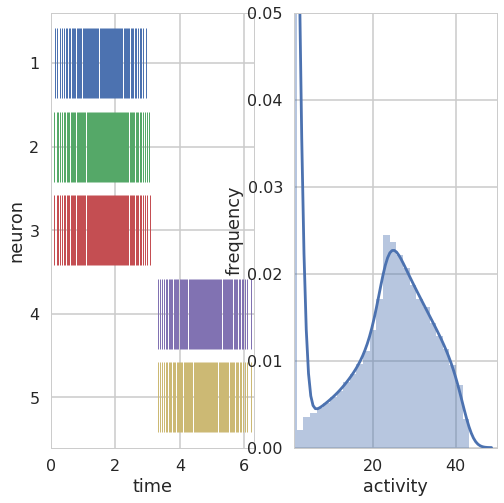

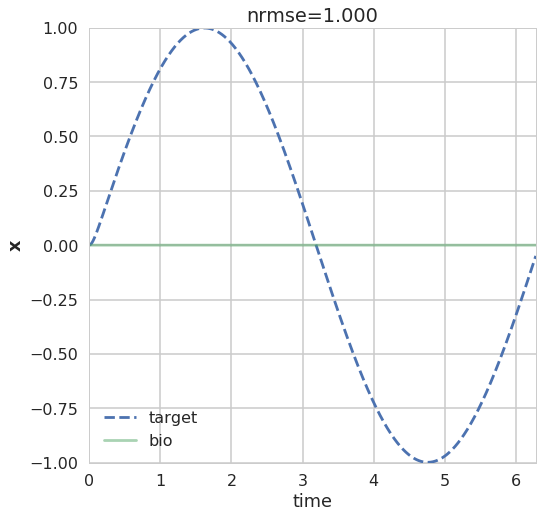

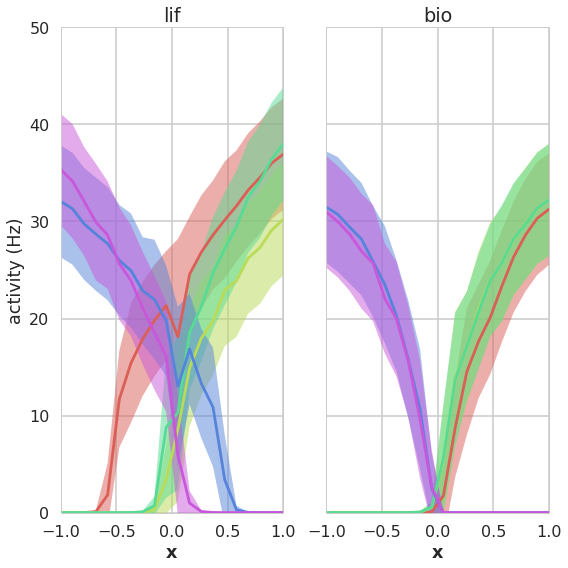

Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Simulating finished in 0:02:11.                                                 


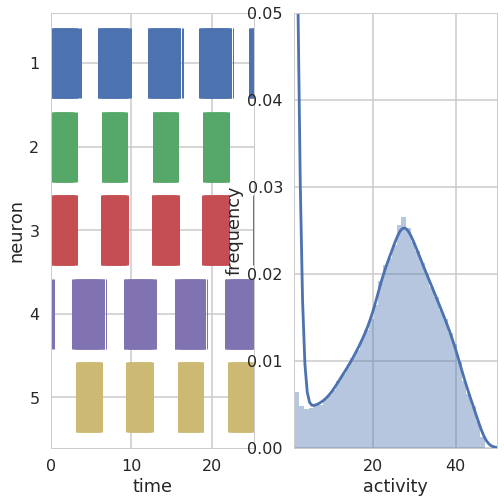

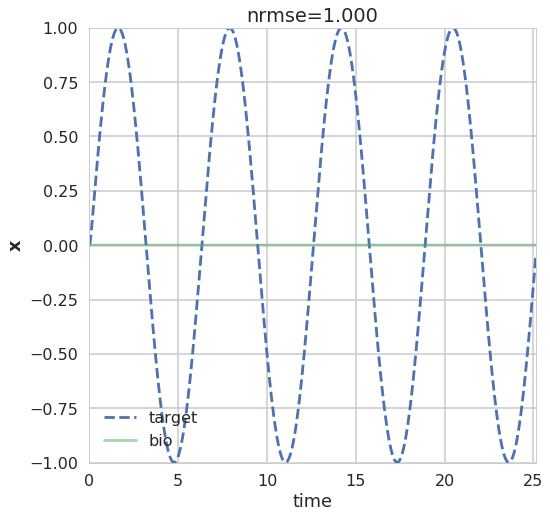

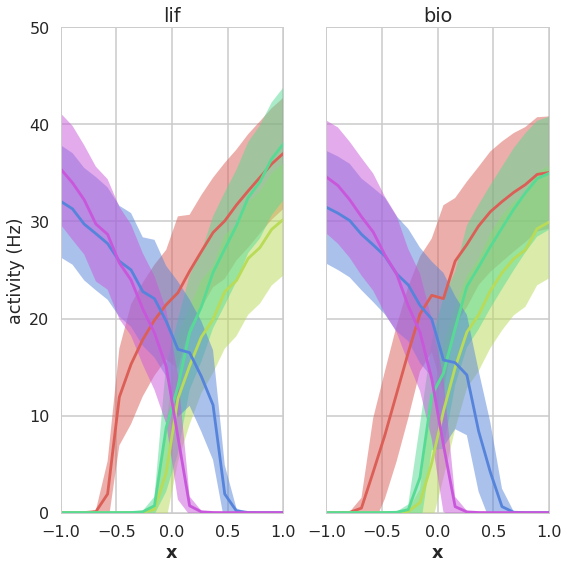

Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Simulating finished in 0:02:05.                                                 


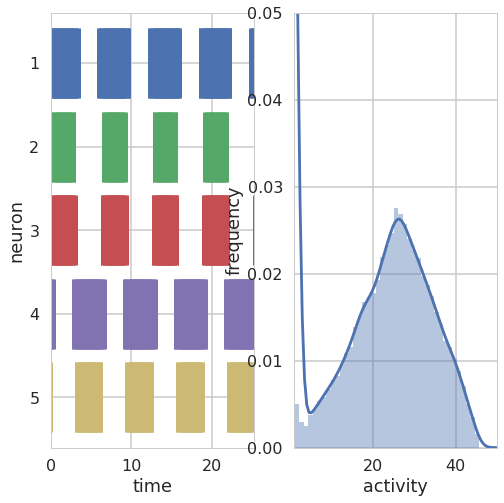

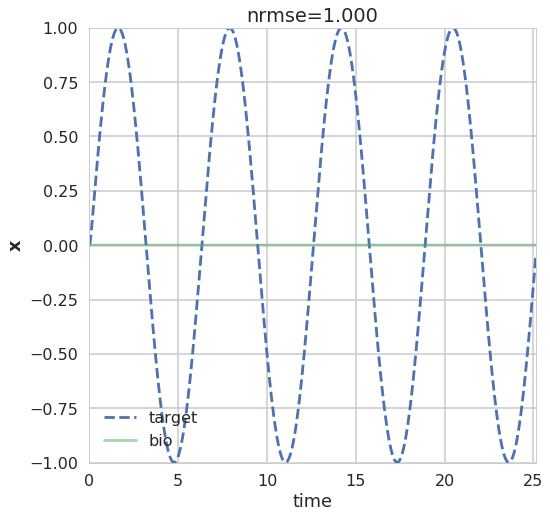

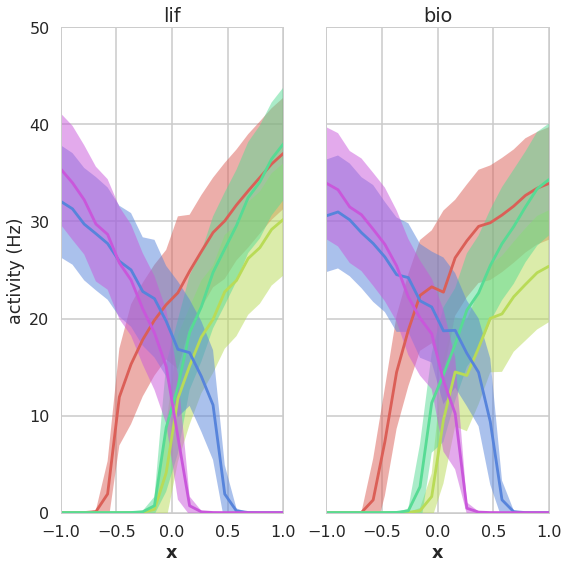

In [7]:
n_neurons = 5
n_syn = 2
freq = 1
eta = 0

d_bio_out_init = np.zeros((n_neurons, 1))
syn_weights_init = np.zeros((n_neurons, 100, n_syn))

t = 2*np.pi
_, _ = pre_bio(
    d_bio_out_init,
    t=t,
    freq=freq,
    n_neurons=n_neurons,
    n_syn=n_syn,
    eta=eta,
    syn_weights=syn_weights_init,
    verbose=True)

t = 8*np.pi
eta = 1e-2
_, syn_weights = pre_bio(
    d_bio_out_init,
    t=t,
    freq=freq,
    n_neurons=n_neurons,
    n_syn=n_syn,
    eta=eta,
    syn_weights=syn_weights_init,
    verbose=True)

t = 8*np.pi
_, _ = pre_bio(
    d_bio_out_init,
    t=t,
    freq=freq,
    n_neurons=n_neurons,
    n_syn=n_syn,
    eta=eta,
    syn_weights=syn_weights,
    learning=False,
    verbose=True)